## 3 Unsupervised Learning

Implement self-taught learning using an Autoencoder and a 3-layer Neural Network to solve a multi-class classification task on real-world data.

### I Load Task2C labeled.csv, Task2C unlabeled.csv, and Task2C test.csv datasets

In [794]:
#import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm as cm
import torch

In [795]:
#get external files
pd_train_lab = pd.read_csv('Task2C_labeled.csv')
pd_train_unlab = pd.read_csv('Task2c_unlabeled.csv')
pd_test = pd.read_csv('Task2C_test.csv')

In [796]:
pd_train_lab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Columns: 785 entries, label to pixel_783
dtypes: int64(785)
memory usage: 306.8 KB


In [797]:
pd_train_lab.head()

,label,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_774,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [798]:
#function to plot images
def show_img(file, label=True, size=[10,10]):
    n = len(file)
    plt.figure(figsize=(size[0], size[1]), tight_layout=True)

    for i in range(n):
        img = file.iloc[i].values #get row
        if label: 
            try: img_title = file.iloc[i].label
            except: 
                print('no label')
                break
            img = img[1:]
        img = img.reshape(28, 28)
        if i + 1 > size[0]**2: break
        ax = plt.subplot(size[0], size[1], i + 1)
        if label: plt.title(img_title)
        plt.imshow(img, cmap='gray')
        ax.axis('off')
    plt.show()

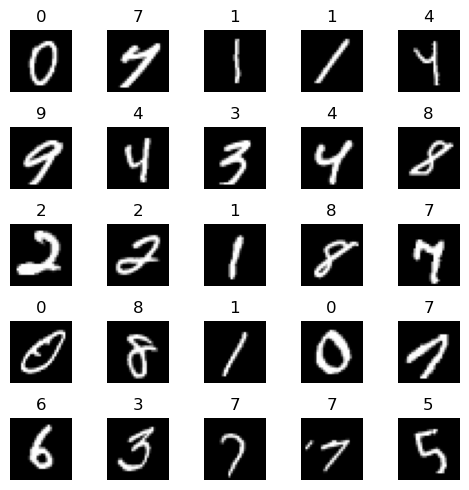

In [799]:
show_img(pd_train_lab, label=True, size=[5,5])

### II Train an autoencoder with only one hidden layer and change the number of its neurons

In [800]:
from torch import tensor
from torch.optim import Adam
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [801]:
def get_dataloader(X_train, Y_train=None, autoencoder=False, bs=128, standardize=True, return_dataset=False):
    """
    Retrieves a data loader to use for training. In case autoencoder=True, Y_train automatically is set to X_train
    The function returns the dataloader only if return_dataset is False otherwise it returns a tuple (dataloader,train_dataset)
    where train_dataset is the Dataset object after preprocessing.
    """
    try:
        X_train= np.array(X_train).astype(np.float32)
        if standardize: X_train = normalize(X_train)
        if not autoencoder: Y_train = np.array(Y_train)
    except Exception as e:
        raise Exception('Make sure your input and labels are array-likes. Your input failed with exception: %s'%e)
    # transform into tensors
    if autoencoder:
        Y_train = X_train
    
    X_train, Y_train = map(tensor, (X_train, Y_train))
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    X_train = X_train.to(device)
    Y_train = Y_train.to(device)
            
    train_ds = TensorDataset(X_train,Y_train)
    train_dl = DataLoader(train_ds, batch_size=16)
    
    if return_dataset: return train_dl,train_ds
    
    return train_dl

def normalize(x, m=None, s=None): 
    if m is None or s is None:
        #print('Normalizing data: No mean and/or sd given. Assuming it is training data')
        m,s = x.mean(), x.std()
        
    return (x-m)/s

In [802]:
def train_autoencoder(X_train, hidden, activation='Tanh', epochs=10, trace=False, **kwargs):
    """
    Trains an Autoencoder and returns the trained model
    
    Params:
    X_train: Input data to train the autoencoder. Can be a dataframe, numpy, 2-D list or a tensor with 2 dimensions (batch_size, flattened_image_size)
    hidden: a list of sizes for the hidden layers ex: ([100,2,100]) will train an autoencoder with 3 layers
    activation (default='Tanh'): Activation type for hidden layers, output layer will always have a linear activation
    epochs: Number of epochs to train autoencoder
    trace: if true, will display epoch progress and will plot the loss plot at the end of training
    **kwargs: passed to Adam optimizer, lookup adam optimizer for more details
    """
    train_dl = get_dataloader(X_train, autoencoder=True)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # Building the autoencoder
    n_inps = [X_train.shape[-1]]
    n_out = n_inps
    layer_dims = n_inps + hidden + n_out
    layers = []
    try:
        non_linearity = getattr(nn,activation)()
    except AttributeError:
        raise Exception('Activation type not found, note that it is case senstive (ex: Tanh, Sigmoid,ReLU)')
        
    for i in range(len(layer_dims)-1):
        layers.extend([nn.Linear(layer_dims[i], layer_dims[i+1]), non_linearity])
    
    layers.pop()  # to remove the last non-linearity

    model = nn.Sequential(*layers)
    model = model.to(device)
#     print('Training Model on %s'%(device))
    # to capture training loss
    losses = []
    epoch_losses = []
    # define optimizer with learning rate
    optim = Adam(model.parameters(), **kwargs)
    # we use MSE error for reconstruction loss
    loss_criterion = nn.MSELoss()
    # calculate printing step - optional
    printing_step = int(epochs/10)
    # start training
    for epoch in range(epochs):
        for xb,yb in train_dl:
            preds = model(xb)
            loss = loss_criterion(preds,yb)
            losses.append(loss.item())
            loss.backward()
            optim.step()
            model.zero_grad()
        # after epoch
        epoch_loss = np.mean(losses[-len(train_dl):]) # average loss across all batches
        epoch_losses.append(epoch_loss)
#         if trace: and not epoch%printing_step:
#             print(f'Epoch {epoch} out of {epochs}. Loss:{epoch_loss}')

    return model, epoch_losses

#method to further train model with unlabelled data
def retrain_autoencoder(model, X_train, epochs=10, trace=False, **kwargs):
    train_dl = get_dataloader(X_train, autoencoder=True)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    losses = []
    epoch_losses = []

    optim = Adam(model.parameters(), **kwargs)
    loss_criterion = nn.MSELoss()

    printing_step = int(epochs / 10)

    for epoch in range(epochs):
        for xb, yb in train_dl:
            preds = model(xb)
            loss = loss_criterion(preds, yb)
            losses.append(loss.item())
            loss.backward()
            optim.step()
            model.zero_grad()

        epoch_loss = np.mean(losses[-len(train_dl):])
        epoch_losses.append(epoch_loss)

    return model, epoch_losses

In [803]:
#function to calculate autoencoder losses across range of neuron choices 
def neurons_err(x_lab, x_unlab, epochs=10, lr=0.001, activation='Tanh', n_neurons=np.arange(20,230,40)):
    auto_errors = []
    models = []
    loss_criterion = nn.MSELoss()
    for _, n in enumerate(n_neurons):
        #train using labelled data
        model, _ = train_autoencoder(    
            X_train = x_lab, # training data
            hidden = [n], # number of layers and their units
            epochs = epochs, # maximum number of epochs  
            activation = activation, # activation function
            lr = lr,   #learning rate
            trace=True
        )
        
        #additional training using unlabelled data
        model_plus, errors = retrain_autoencoder(model, x_unlab, epochs=10)
        
        auto_errors.append(errors)
        models.append(model_plus)
    return models, np.asarray(auto_errors)

#### III Calculate and record the reconstruction error for the autoencoder... Plot these values

In [804]:
#record encoder errors for range of neuron choices
#per project requirements use both labeled and unlabeled data to train the autoencoder
n_neurons = np.arange(20,221,40)
x_train_lab = pd_train_lab.iloc[:,1:].values
x_train_unlab = pd_train_unlab.values

auto_models, auto_errs = neurons_err(x_train_lab, x_train_unlab, n_neurons=n_neurons)

In [805]:
#get mean error for each row (corresponding to 10 iterations/epochs)
mean_errs = auto_errs.mean(axis=1)

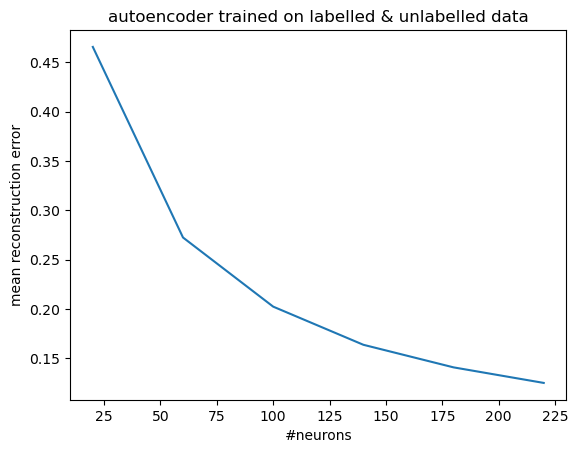

In [806]:
#plot neuron number vs error rates
plt.plot(n_neurons, mean_errs)
plt.title('autoencoder trained on labelled & unlabelled data')
plt.xlabel('#neurons')
plt.ylabel('mean reconstruction error')
plt.show()

#### Findings based on the plot.

The above plot demonstrates a correlation between neuron number and error rate. As the number of neurons increase we see an initial sharp decrease in error. The trend begin to plateau as the number of neurons reaches large values implying diminishing returns.

### IV Build the 3-layer NN to build a classification model using all the original attributes from the training set and change the number of its neurons 

In [807]:
class NNet():
    
    def __init__(self, K=3, epoch_max=1000, eta=0.1, alpha=0.001):
        # Setting parameters
        self.K = K # number of units in the hidden layer
        self.epoch_max = epoch_max # maximum number of iterations
        self.eta = eta # learning rate
        self.alpha = alpha # regularization term
    
    ## the activation function (sigmoid here)
    def h(self, z):
        return (1/(1+np.exp(-3*z)))

    ## the derivitive of the activation function (sigmoid here)
    def h_d(self, z):
        return (self.h(z)*(1-self.h(z)))

    ## Accuracy
    def accuracy(self, pred, label):
        return (pred == label).mean()
    
    def feedforward(self, Xi, Ti):
        ### 1st (input) layer 
        a1 = Xi                           
        y = Ti                          
        ### 2nd (hidden) layer
        z2 = a1 @ self.W1 + self.b1                            
        a2 = self.h(z2)                                  
        ### 3rd (output) layer
        z3 = a2 @ self.W2 + self.b2                         
        a3 = self.h(z3)                            
        return(a1, a2, a3, y, z2, z3)

    def backpropagation(self, Ti, z2, z3, a3):
        ### 3rd (output) layer
        d3 = -(Ti-a3) * self.h_d(z3)                          
        ### 2nd (hidden) layer
        d2 =  (d3 @ self.W2.T) * self.h_d(z2)                          
        return(d2,d3)

    def prediction(self, X, threshold=0.5):
        # we use the feedforward network we defined to obtain output activation (a3)
        _,_, a3,_,_,_ = self.feedforward(X, 1)
        return np.array([1 if above_thresh else 0 for above_thresh in (a3 >= threshold)]).reshape(-1,1)
    

    def train_test(self, X1, X2, T1, T2, seed=None):
        if seed is not None: np.random.seed(seed)
        # Setting parameters
        N,D = X1.shape

        # initialization
        epoch = 1 # epoch (iteration) counter
        terminate = False   # termination criteria

        #intialise weights and bias terms
        self.W1 = np.random.normal(scale=0.5, size=(D,self.K)) * 0.01
        self.b1 = np.zeros((1,self.K))
        self.W2 = np.random.normal(scale=0.5, size=(self.K,1)) * 0.01
        self.b2 = np.zeros((1,1))
        
        ## tracing accuracy of the model 
        train_accuracy = []
        test_accuracy = []

        # main loop
        while (not terminate):

            ## Feedforward:
            a1, a2, a3, y, z2, z3 = self.feedforward(X1, T1)

            ## Backpropagation:
            d2, d3 = self.backpropagation(T1, z2, z3, a3)

            ## calculate the delta values
            ### 1st layer
            W1_d = a1.T @ d2
            b1_d = d2
            ### 2nd layer
            W2_d = a2.T @ d3
            b2_d = d3

            ## update weight vectors and matrices
            ### 1st (input) layer
            self.W1 = self.W1 - self.eta * (W1_d/N + self.alpha*self.W1)
            self.b1 = self.b1 - self.eta * (b1_d.mean(axis=0, keepdims=True))
            ### 2nd (hidden) layer
            self.W2 = self.W2 - self.eta * (W2_d/N + self.alpha*self.W2)
            self.b2 = self.b2 - self.eta * (b2_d.mean(axis=0, keepdims=True))

            ## trace train and test accuracy
            train_accuracy.append(self.accuracy(self.prediction(X1), T1))
            test_accuracy.append(self.accuracy(self.prediction(X2), T2))
            ## increase the iteration counter
            epoch = epoch + 1

            ## check the termination criteria
            if (epoch >= self.epoch_max): terminate = True

        return (train_accuracy,test_accuracy)

In [860]:
#set variables to pass to neural network
X1 = pd_train_lab.iloc[:,1:].values
X2 = pd_test.iloc[:,1:].values
T1 = pd_train_lab.iloc[:,0].values
T2 = pd_test.iloc[:,0].values

T1 = np.asarray(T1).reshape(-1, 1)
T2 = np.asarray(T2).reshape(-1, 1)

In [861]:
# #standardise values as having issues passing to NN
# from sklearn.preprocessing import StandardScaler  
# scaler = StandardScaler()
# scaler.fit(X1)
# X1 = scaler.transform(X1)  
# X2 = scaler.transform(X2)

In [862]:
from sklearn.metrics import zero_one_loss

#function to calculate and record NN test errors for range of k
def nnet_ks1(X1,X2,T1,T2, n_neurons=n_neurons):
    nn_err = []
    test_acc = []
    for _, k in enumerate(n_neurons):
        print(f'training {k} neurons')
        nnet = NNet(K=k, epoch_max=2500, eta=0.01, alpha=1e-5)

        #get accuracy
        _, test = nnet.train_test(X1, X2, T1, T2, seed=1)
        test_acc.append(test)

        #get zero-one loss
        nn_err.append([k, zero_one_loss(nnet.prediction(X2), T2)])

    test_acc = np.asarray(test_acc)
    nn_err = np.asarray(nn_err)
    return test_acc, nn_err

In [863]:
_, nn_err1 = nnet_ks1(X1,X2,T1,T2, n_neurons=n_neurons)

training 20 neurons
training 60 neurons
training 100 neurons
training 140 neurons
training 180 neurons
training 220 neurons


In [864]:
nn_err1

array([[ 20.   ,   0.904],
       [ 60.   ,   0.904],
       [100.   ,   0.904],
       [140.   ,   0.904],
       [180.   ,   0.904],
       [220.   ,   0.904]])

**NOTE: There appears to be an issue with the above neural network implementation as errors are the same across the range of neurons. To complete the task MLPClassifier is imported below to have valid data to use in the follow-on exercises.**

In [813]:
from sklearn.neural_network import MLPClassifier

##neural network classifier function
#calculate and record test errors for range of k
def nnet_ks2(X1, X2, T1, T2, random_state=1, alpha=1e-5, n_neurons=n_neurons, verbose=True):
    nn_err = []
    for _, k in enumerate(n_neurons):
        if verbose: print(f'training {k} neurons')
        clf = MLPClassifier(solver='adam', alpha=alpha, hidden_layer_sizes=(k), random_state=random_state, 
                            max_iter=2500)
        clf.fit(X1, T1)
        nn_err.append([k, zero_one_loss(clf.predict(X2), T2)])

    nn_err = np.asarray(nn_err)
    return nn_err

In [916]:
X1 = pd_train_lab.iloc[:,1:].values
T1 = pd_train_lab.iloc[:,0].values
nn_err2 = nnet_ks2(X1, X2, T1, T2, random_state=1, n_neurons=n_neurons)
nn_err2

training 20 neurons
training 60 neurons
training 100 neurons
training 140 neurons
training 180 neurons
training 220 neurons


array([[ 20.   ,   0.76 ],
       [ 60.   ,   0.572],
       [100.   ,   0.576],
       [140.   ,   0.552],
       [180.   ,   0.482],
       [220.   ,   0.44 ]])

### V Build augmented self-taught networks using the models from Step II.
#### For each model:
1) Add the output of the middle layer of an autoencoder as extra features to the original feature set
2) Train a new 3-layer Neural Network using all features (original + extra) and varying the number of hidden neurons (like Step IV) as well.
3) Then calculate and record the test error.

In [815]:
def get_deepfeatures(trained_model, X_input, layer_number):
    '''
    Gets deep features of a given `layer_number` upon passing `X_input` through a `trained_model`   
    '''
    X_input = get_dataloader(X_input,autoencoder=True,return_dataset=True)[1].tensors[0]
    result = []
    def save_result(m,i,o):
        result.append(o.data)
    hook = trained_model[layer_number].register_forward_hook(save_result)

    with torch.no_grad():
        trained_model(X_input)

    hook.remove()
    
    return (result[0].cpu().numpy())

In [889]:
#function to build neural networks using autoencoder features
#for each autoencoder extra-feature set run NN for range of k
def build_nets(X1, X2, T1, T2, auto_models=auto_models, n_neurons=n_neurons, random_state=1):
    errs = []
    for i, model in enumerate(auto_models):
        print(f'training..')
        #extract deep features from autoencoder for train and test sets
        deep_feats1 = np.asarray(get_deepfeatures(model, X1, layer_number=1))
        deep_feats2 = np.asarray(get_deepfeatures(model, X2, layer_number=1))
              
        #concatenate train and test data with new features
        X1_all = np.concatenate([X1, deep_feats1], axis=1)
        X2_all = np.concatenate([X2, deep_feats2], axis=1)
        print(f'#extra features: {X1_all.shape[1]-len(pd_train_lab.columns)+1}')
        
        #train neural network with all features (original + new) across range of k and get errors
        errs.append(nnet_ks2(X1_all, X2_all, T1, T2, random_state=random_state, verbose=False))

    return np.asarray(errs)

In [820]:
aug_errs = build_nets(X1, X2, T1, T2, auto_models=auto_models, n_neurons=n_neurons, random_state=None)

training..
#extra features: 20
training..
#extra features: 60
training..
#extra features: 100
training..
#extra features: 140
training..
#extra features: 180
training..
#extra features: 220


In [945]:
#read aug_errs in pandas dataframe for easy viewing.
#cols = #neurons in NN
#rows = #extra_features from autoencoder (20,60,100,140,180,220)
df_aug_err = pd.DataFrame([aug_errs[i][:,1] for i in range(len(aug_errs))], columns=n_neurons)
df_aug_err

,20,60,100,140,180,220
0,0.638,0.552,0.570,0.548,0.486,0.534
1,0.618,0.510,0.530,0.496,0.500,0.464
2,0.708,0.596,0.544,0.510,0.550,0.524
3,0.590,0.540,0.514,0.524,0.438,0.500
4,0.650,0.514,0.520,0.558,0.556,0.468
5,0.600,0.600,0.540,0.514,0.448,0.496


In [954]:
#get column means for each k value for plotting
aug_err_means = df_aug_err.mean(axis=0)

### VI Plot the error rates for the 3-layer neural networks from Step IV and the augmented self- taught networks from Step V

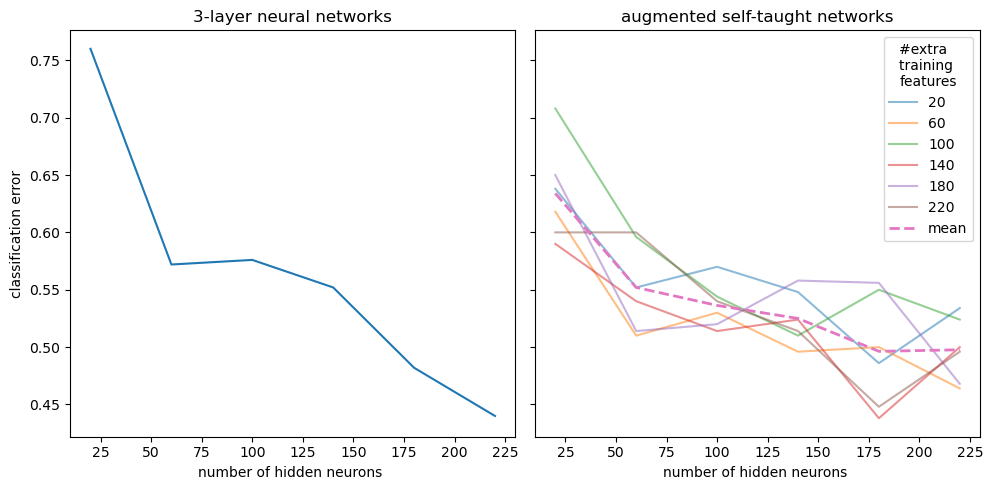

In [982]:
_, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True, tight_layout=True)

ax[0].plot(n_neurons, nn_err2[:,1], label=20+i*40)

for i in range(len(aug_errs)):
    ax[1].plot(n_neurons, aug_errs[i][:,1], label=20+i*40, alpha=0.5)

ax[1].plot(n_neurons, aug_err_means, linestyle='--', linewidth=2, label='mean')

for j in range(2):
    ax[j].set_xlabel('number of hidden neurons ')
    ax[j].set_title('3-layer neural networks' if j==0 else 'augmented self-taught networks')
ax[1].legend(title='#extra \ntraining \nfeatures')
ax[0].set_ylabel('classification error')
plt.show()

#### Difference in performance of the 3-layer neural networks and the augmented self-taught networks

The augmented networks use additional features (in addition to the original feature-set) obtained from our autoencoder. The autoencoder is first trained on labelled data (Task2C_labeled.csv) and then further trained on unlabelled data (Task2c_unlabeled.csv). We then derive the middle layer from the trained autoencoder model, which is representation of the data with reduced dimensionality, and concatenate these additional features with our original features. The networks are then trained on these augmented features across a range of k values. 

Given the expanded feature-set we expect to see better performance in the augmented models compared to the standard 3-layer neural networks (NN) which are trained only on labelled data with the original (standard) feature-set. 

While both models demonstrate an inverse correlation between errors and number of neurons, as well as achieving similar minimum error scores overall, if we compare model performance at each specific neuron configruation we see the augmented model requires fewer neurons to achieve the same level of performance. Indeed the lowest error of ~0.45 occurs around ~175 neurons (with +140 training features) for the augmented model, compared to around ~220 neurons for the NN. This is likely due to the additional feautures provided to the augmented models, which distills the key information, then requiring less 'horse-power' to comprehend the dataset and succcessfully predict the test data. The resulting augmented model achieves similar performance to the NN but is less computationally intensive.